<a href="https://colab.research.google.com/github/ShamitRoyChowdhury/Twitter-Sentiment-Analysis/blob/master/twitter_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
mounted = drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Twitter Sentimental Analysis








In [0]:
get_ipython().system('pip install gensim --upgrade')
get_ipython().system('pip install keras --upgrade')
get_ipython().system('pip install pandas --upgrade')

     |████████████████████████████████| 24.2MB 130kB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 378kB 3.4MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5
Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (0.25.3)


In [0]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential,load_model
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Using TensorFlow backend.


In [0]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Settings

In [0]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = r"/content/gdrive/My Drive/model.h5"
WORD2VEC_MODEL = "/content/gdrive/My Drive/model.w2v"
TOKENIZER_MODEL = "/content/gdrive/My Drive/tokenizer.pkl"
ENCODER_MODEL = "/content/gdrive/My Drive/encoder.pkl"

### Read Dataset

### Dataset details
* **target**: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
* **ids**: The id of the tweet ( 2087)
* **date**: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
* **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.
* **user**: the user that tweeted (robotickilldozr)
* **text**: the text of the tweet (Lyx is cool)

In [0]:
# dataset_filename = os.listdir("../input")[0]
dataset_path = r"/content/gdrive/My Drive/dataset.csv" # os.path.join("..","input",dataset_filename)
print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

Open file: /content/gdrive/My Drive/dataset.csv


In [0]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [0]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### Map target label to String
* **0** -> **NEGATIVE**
* **2** -> **NEUTRAL**
* **4** -> **POSITIVE**

In [0]:

decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]


In [0]:
get_ipython().run_cell_magic('time', '', 'df.target = df.target.apply(lambda x: decode_sentiment(x))')

CPU times: user 435 ms, sys: 3.16 ms, total: 438 ms
Wall time: 438 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

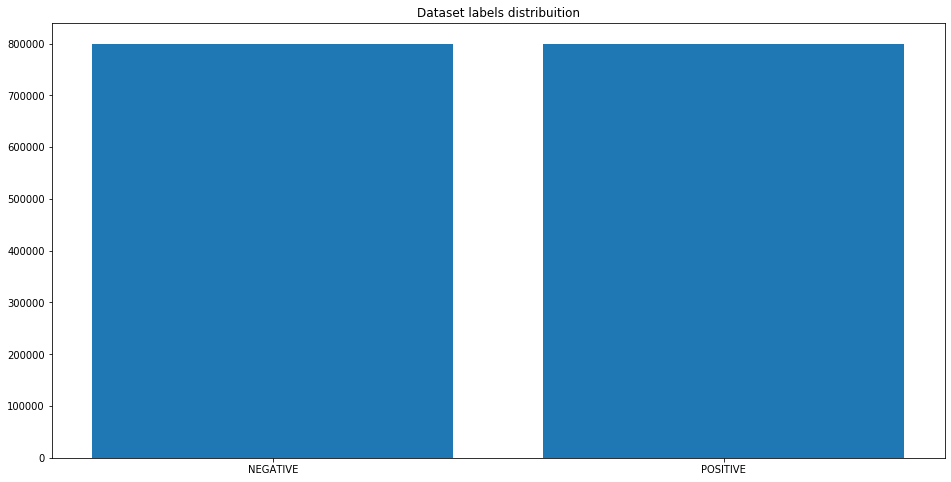

In [0]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

### Pre-process dataset

In [0]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [0]:
def preprocess(text, stem=False):
    # Remove link,user,special characters and stopwords 
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [0]:
get_ipython().run_cell_magic('time', '', 'df.text = df.text.apply(lambda x: preprocess(x))')

CPU times: user 40.3 s, sys: 98.5 ms, total: 40.4 s
Wall time: 40.4 s


### Split train and test

In [0]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


### Word2Vec

In [0]:
get_ipython().run_cell_magic('time', '', 'documents = [_text.split() for _text in df_train.text]')


CPU times: user 2.61 s, sys: 268 ms, total: 2.87 s
Wall time: 2.88 s


In [0]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [0]:
w2v_model.build_vocab(documents)

2020-01-17 05:42:05,746 : INFO : collecting all words and their counts
2020-01-17 05:42:05,748 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-01-17 05:42:05,772 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2020-01-17 05:42:05,794 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2020-01-17 05:42:05,812 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2020-01-17 05:42:05,830 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2020-01-17 05:42:05,848 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2020-01-17 05:42:05,867 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2020-01-17 05:42:05,887 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2020-01-17 05:42:05,906 : INFO : PROGRESS: at s

In [0]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [0]:
get_ipython().run_cell_magic('time', '', 'w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)')

2020-01-17 05:42:22,712 : INFO : training model with 8 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2020-01-17 05:42:23,744 : INFO : EPOCH 1 - PROGRESS: at 4.78% examples, 385361 words/s, in_qsize 15, out_qsize 0
2020-01-17 05:42:24,793 : INFO : EPOCH 1 - PROGRESS: at 10.20% examples, 405512 words/s, in_qsize 15, out_qsize 0
2020-01-17 05:42:25,795 : INFO : EPOCH 1 - PROGRESS: at 16.16% examples, 432658 words/s, in_qsize 16, out_qsize 0
2020-01-17 05:42:26,860 : INFO : EPOCH 1 - PROGRESS: at 21.24% examples, 422460 words/s, in_qsize 14, out_qsize 1
2020-01-17 05:42:27,917 : INFO : EPOCH 1 - PROGRESS: at 26.88% examples, 425627 words/s, in_qsize 15, out_qsize 4
2020-01-17 05:42:29,003 : INFO : EPOCH 1 - PROGRESS: at 32.84% examples, 430043 words/s, in_qsize 16, out_qsize 2
2020-01-17 05:42:30,008 : INFO : EPOCH 1 - PROGRESS: at 38.14% examples, 430679 words/s, in_qsize 15, out_qsize 0
2020-01-17 05:42:31,065 : INFO : EPOCH 1 - PROGRESS: 

CPU times: user 19min 14s, sys: 4.63 s, total: 19min 18s
Wall time: 9min 52s


(263129787, 295270528)

In [0]:
w2v_model.most_similar("love")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2020-01-17 05:53:05,512 : INFO : precomputing L2-norms of word weight vectors


[('luv', 0.570814847946167),
 ('loves', 0.5598657131195068),
 ('loved', 0.5442669987678528),
 ('adore', 0.527519702911377),
 ('looove', 0.5096513628959656),
 ('amazing', 0.5040900111198425),
 ('awesome', 0.4626478850841522),
 ('loveee', 0.4624171555042267),
 ('lovee', 0.457017719745636),
 ('loooove', 0.4519737660884857)]

### Tokenize Text

In [0]:
get_ipython().run_cell_magic('time', '', 'tokenizer = Tokenizer()\ntokenizer.fit_on_texts(df_train.text)\n\nvocab_size = len(tokenizer.word_index) + 1\nprint("Total words", vocab_size)')

Total words 290419
CPU times: user 17.1 s, sys: 69 ms, total: 17.2 s
Wall time: 17.2 s


In [0]:
get_ipython().run_cell_magic('time', '', 'x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)\nx_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)')

CPU times: user 24.1 s, sys: 460 ms, total: 24.6 s
Wall time: 24.6 s


### Label Encoder



In [0]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [0]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [0]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [0]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

### Embedding Layer

In [0]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)


(290419, 300)


In [0]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

### Building the Model

In [0]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


2020-01-17 05:55:22,788 : WARNING : From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          87125700  
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


In [0]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2020-01-17 05:55:38,465 : WARNING : From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/nn_impl.py:183: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Callbacks

In [0]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

### Train

In [0]:
get_ipython().run_cell_magic('time', '', 'history = model.fit(x_train, y_train,\n                    batch_size=BATCH_SIZE,\n                    epochs=EPOCHS,\n                    validation_split=0.1,\n                    verbose=1,\n                    callbacks=callbacks)')

2020-01-17 05:55:56,319 : WARNING : From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Train on 1152000 samples, validate on 128000 samples
Epoch 1/8
1152000/1152000 [==============================] - 351s 304us/step - loss: 0.5070 - accuracy: 0.7482 - val_loss: 0.4626 - val_accuracy: 0.7793
Epoch 2/8


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


1152000/1152000 [==============================] - 352s 305us/step - loss: 0.4826 - accuracy: 0.7648 - val_loss: 0.4574 - val_accuracy: 0.7842
Epoch 3/8
1152000/1152000 [==============================] - 348s 302us/step - loss: 0.4755 - accuracy: 0.7693 - val_loss: 0.4518 - val_accuracy: 0.7864
Epoch 4/8
1152000/1152000 [==============================] - 355s 308us/step - loss: 0.4717 - accuracy: 0.7720 - val_loss: 0.4511 - val_accuracy: 0.7878
Epoch 5/8
1152000/1152000 [==============================] - 359s 312us/step - loss: 0.4691 - accuracy: 0.7737 - val_loss: 0.4493 - val_accuracy: 0.7883
Epoch 6/8
1152000/1152000 [==============================] - 358s 311us/step - loss: 0.4744 - accuracy: 0.7707 - val_loss: 0.4609 - val_accuracy: 0.7812
Epoch 7/8
1152000/1152000 [==============================] - 356s 309us/step - loss: 0.4812 - accuracy: 0.7665 - val_loss: 0.4537 - val_accuracy: 0.7845
Epoch 8/8
1152000/1152000 [==============================] - 356s 309us/step - loss: 0.4761 

### Evaluate

In [0]:
get_ipython().run_cell_magic('time', '', 'score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)\nprint()\nprint("ACCURACY:",score[1])\nprint("LOSS:",score[0])')

320000/320000 [==============================] - 42s 131us/step

ACCURACY: 0.7871906161308289
LOSS: 0.44952336411476135
CPU times: user 57.9 s, sys: 4.15 s, total: 1min 2s
Wall time: 41.9 s


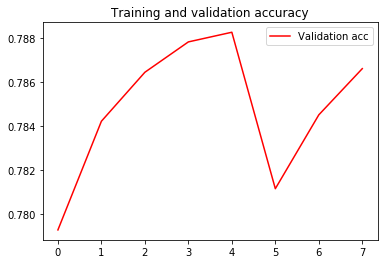

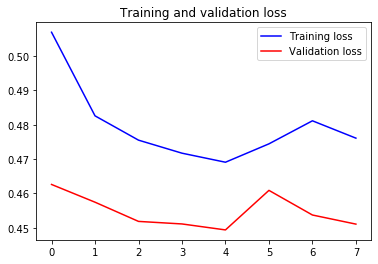

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
# plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### Predict

In [0]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [0]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}

In [0]:
predict("woah! worst day of my life!!")

{'elapsed_time': 1.7333588600158691,
 'label': 'NEGATIVE',
 'score': 0.027576861903071404}

### Confusion Matrix

In [0]:
get_ipython().run_cell_magic('time', '', 'y_pred_1d = []\ny_test_1d = list(df_test.target)\nscores = model.predict(x_test, verbose=1, batch_size=8000)\ny_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]')


320000/320000 [==============================] - 24s 75us/step
CPU times: user 11.3 s, sys: 1.67 s, total: 13 s
Wall time: 24.5 s


In [0]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)


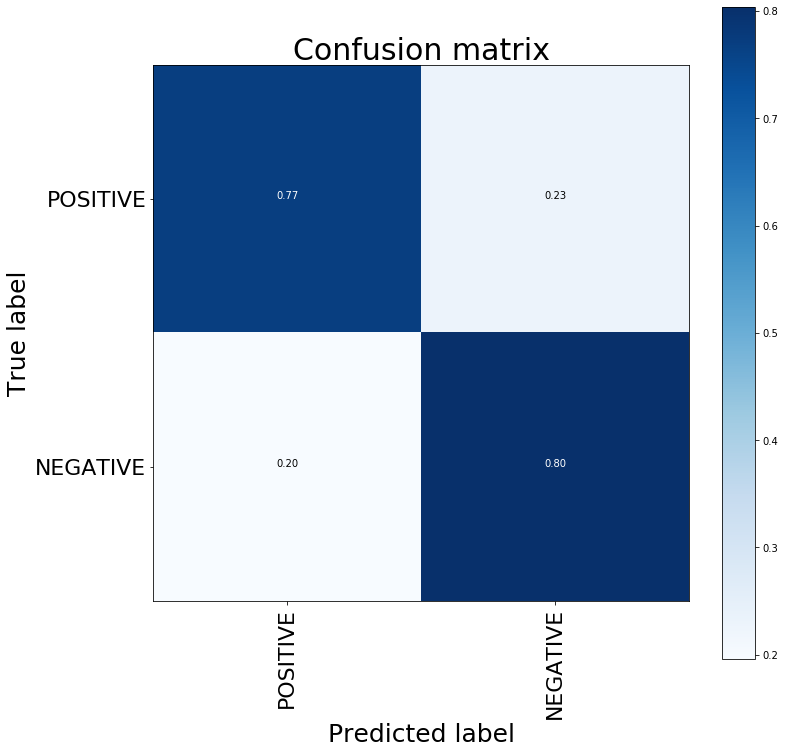

CPU times: user 1.08 s, sys: 27.3 ms, total: 1.1 s
Wall time: 1.12 s


In [0]:
get_ipython().run_cell_magic('time', '', '\ncnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)\nplt.figure(figsize=(12,12))\nplot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")\nplt.show()')


### Classification Report

In [0]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.80      0.77      0.78    159494
    POSITIVE       0.78      0.80      0.79    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



### Accuracy Score

In [0]:
accuracy_score(y_test_1d, y_pred_1d)


0.787190625

### Save Model

In [0]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

2020-01-17 07:21:20,500 : INFO : saving Word2Vec object under /content/gdrive/My Drive/model.w2v, separately None
2020-01-17 07:21:20,502 : INFO : not storing attribute vectors_norm
2020-01-17 07:21:20,504 : INFO : not storing attribute cum_table
2020-01-17 07:21:21,660 : INFO : saved /content/gdrive/My Drive/model.w2v


### Load Model


In [0]:
model = load_model(KERAS_MODEL)
with open(TOKENIZER_MODEL, 'rb') as handle:
    tokenizer = pickle.load(handle)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


2020-01-19 05:40:49,448 : WARNING : From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2020-01-19 05:40:58,904 : WARNING : From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/nn_impl.py:183: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2020-01-19 05:40:59,577 : WARNING : From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

